In [1]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

<h1>경로 및 필터링 문자열 지정</h1>

In [2]:
# 데이터가 저장된 최상위 폴더 경로 (이미지지)
image_base_dir = r"C:\Work\git_hub\human_da\Final_Project\oos\Data\Skin_Data\Training\Image_Data\Smart_Phone"
# 필터링할 문자열
extensions = "F.jpg"

In [3]:
#경로지정 (메타데이터터)
json_base_dir = r"C:\Work\git_hub\human_da\Final_Project\oos\Data\Skin_Data\Training\Labeling_Data\Smart_Phone"
# 필터링할 문자열
file_suffix = "F_01.json"

In [4]:
# 이미지 읽는 함수
def load_images_from_folders(base_dir, extensions=".jpg"):
    """
    지정한 폴더 내에서 특정 확장자를 가진 이미지를 로드하는 함수.

    Parameters:
        base_dir (str): 탐색할 최상위 폴더 경로
        extensions (str or tuple): 로드할 이미지 파일의 확장자 (기본값: .jpg)

    Returns:
        dict: {이미지파일명: OpenCV 이미지 객체 (RGB)}
    """
    image_data = {}  # 결과를 저장할 딕셔너리

    # 폴더 순회
    for idx, folder_name in enumerate(os.listdir(base_dir)):
        folder_path = os.path.join(base_dir, folder_name)

        # 폴더인지 확인
        if os.path.isdir(folder_path):
            if idx % 100 == 0:
                print(f"Processing folder: {idx}")

            # 폴더 내 파일 탐색
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)

                # 이미지 파일 처리
                if file_name.endswith(extensions):
                    try:
                        # 한글 경로 처리: 바이너리 읽기 후 OpenCV로 디코딩
                        with open(file_path, 'rb') as f:
                            file_data = np.asarray(bytearray(f.read()), dtype=np.uint8)
                            image = cv2.imdecode(file_data, cv2.IMREAD_COLOR)
                            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환

                        # 이미지 로드 및 저장
                        if image is not None:
                            # 이미지 파일명을 key로 사용
                            image_data[file_name] = image
                        else:
                            print(f"Failed to load image: {file_path}")
                    except Exception as e:
                        print(f"Error loading image {file_path}: {e}")

    print("Image loading complete!")
    return image_data

In [5]:
camera_image_data = load_images_from_folders(base_dir=image_base_dir, extensions=extensions)

Processing folder: 0
Processing folder: 100
Processing folder: 200
Processing folder: 300
Processing folder: 400
Processing folder: 500
Processing folder: 600
Processing folder: 700
Processing folder: 800
Image loading complete!


<h1>메타데이터 불러오기</h1>

In [6]:
def load_json_data(base_dir, file_suffix=".json"):
    """
    주어진 디렉토리 내의 폴더를 순회하며 지정된 접미사로 끝나는 JSON 파일을 로드합니다.

    Args:
        base_dir (str): 탐색할 기본 디렉토리 경로
        file_suffix (str): 찾고자 하는 파일의 접미사 (기본값: ".json")

    Returns:
        dict: 파일 이름(확장자 제외)을 키로 하고 JSON 데이터를 값으로 갖는 딕셔너리
    """
    json_data = {}

    for idx, folder_name in enumerate(os.listdir(base_dir)):
        folder_path = os.path.join(base_dir, folder_name)

        if os.path.isdir(folder_path):
            if idx % 100 == 0:
                print(f"Processing folder: {idx}")

            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)

                if file_name.endswith(file_suffix):
                    try:
                        with open(file_path, "r", encoding="utf-8") as f:
                            one_json_data = json.load(f)
                        file_name_no_ext = os.path.splitext(file_name)[0]
                        json_data[file_name_no_ext] = one_json_data
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

    return json_data

In [7]:
json_data = load_json_data(base_dir=json_base_dir, file_suffix=file_suffix)

Processing folder: 0
Processing folder: 100
Processing folder: 200
Processing folder: 300
Processing folder: 400
Processing folder: 500
Processing folder: 600
Processing folder: 700
Processing folder: 800


<h1>bbox 이용해서 이미지파일 자르기</h1>

In [8]:
def crop_images(image_data, metadata):
    """
    주어진 메타데이터의 바운딩 박스를 기반으로 이미지를 자르고 저장합니다.

    Args:
        image_data (dict): 이미지 파일 이름을 키로 하고 이미지 데이터를 값으로 갖는 딕셔너리
        metadata (dict): JSON 메타데이터, 각 이미지에 대한 바운딩 박스 정보 포함

    Returns:
        dict: 자른 이미지 데이터를 파일 이름과 함께 저장한 딕셔너리
    """
    cropped_image_dict = {}

    for idx, id in enumerate(metadata.keys()):
        if idx % 100 == 0:
            print(f"Complete: {idx}")

        bbox = metadata[id]['images']['bbox']  # 바운딩 박스 정보 가져오기
        x1, y1, x2, y2 = bbox  # 좌표 분리

        image_file_name = metadata[id]['info']['filename']  # 이미지 파일 이름 조회
        file_name = os.path.splitext(image_file_name)[0]

        image = image_data[image_file_name]  # 이미지 불러오기
        cropped_image = image[y1:y2, x1:x2]  # 이미지 자르기

        cropped_image_dict[f"{file_name}_01"] = cropped_image  # 자른 이미지 저장, _01은 색소침착과 주름이 있는 json파일형식으로 키를 맞춰주기위해 사용용

    return cropped_image_dict


In [9]:
crop_image = crop_images(image_data=camera_image_data, metadata=json_data)

Complete: 0
Complete: 100
Complete: 200
Complete: 300
Complete: 400
Complete: 500
Complete: 600
Complete: 700
Complete: 800


<h1>데이터 병합, 저장 및 불러오기 확인</h1>

In [10]:
# 데이터 병합
Test_Data_Set = {}
Test_Data_Set["Images"] = crop_image
Test_Data_Set["Metadata"] = json_data

In [11]:
# 저장 후 데이터 확인
print(Test_Data_Set.keys())
print(len(Test_Data_Set['Images'].keys()))
print(len(Test_Data_Set['Metadata'].keys()))

dict_keys(['Images', 'Metadata'])
858
858


In [12]:
import pickle

In [13]:
# 파일에 데이터 저장
with open('Smart_Phone_Train_Data_Set.pkl', 'wb') as file:  # 'wb'는 바이너리 쓰기 모드
    pickle.dump(Test_Data_Set, file)

print("저장되었습니다.")

저장되었습니다.


In [14]:
# 저장된 파일 불러오기
with open('Smart_Phone_Train_Data_Set.pkl', 'rb') as file:  # 'rb'는 바이너리 읽기 모드
    Test_Data = pickle.load(file)

print("파일에서 데이터를 불러왔습니다.")

파일에서 데이터를 불러왔습니다.


dict_keys(['Images', 'Metadata'])
dict_keys(['0002_03_F_01', '0003_03_F_01', '0006_03_F_01', '0007_03_F_01', '0008_03_F_01', '0009_03_F_01', '0010_03_F_01', '0011_03_F_01', '0012_03_F_01', '0014_03_F_01', '0016_03_F_01', '0017_03_F_01', '0018_03_F_01', '0019_03_F_01', '0020_03_F_01', '0022_03_F_01', '0023_03_F_01', '0024_03_F_01', '0025_03_F_01', '0026_03_F_01', '0027_03_F_01', '0028_03_F_01', '0029_03_F_01', '0030_03_F_01', '0031_03_F_01', '0032_03_F_01', '0033_03_F_01', '0035_03_F_01', '0036_03_F_01', '0037_03_F_01', '0038_03_F_01', '0039_03_F_01', '0040_03_F_01', '0041_03_F_01', '0042_03_F_01', '0043_03_F_01', '0044_03_F_01', '0045_03_F_01', '0046_03_F_01', '0047_03_F_01', '0048_03_F_01', '0049_03_F_01', '0051_03_F_01', '0052_03_F_01', '0054_03_F_01', '0055_03_F_01', '0057_03_F_01', '0058_03_F_01', '0060_03_F_01', '0062_03_F_01', '0064_03_F_01', '0065_03_F_01', '0066_03_F_01', '0068_03_F_01', '0070_03_F_01', '0071_03_F_01', '0073_03_F_01', '0074_03_F_01', '0076_03_F_01', '0077_03_F_

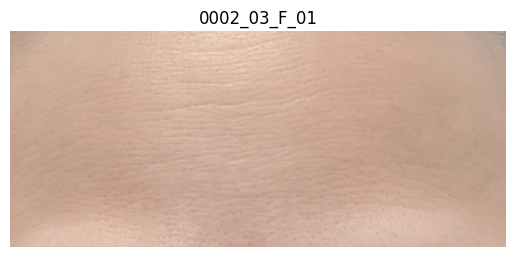

In [16]:
#불러온 데이터 확인
print(Test_Data.keys())
print(Test_Data['Images'].keys())
print(len(Test_Data['Metadata'].keys()))

plt.imshow(Test_Data['Images']['0002_03_F_01'])
plt.axis("off")
plt.title(list(Test_Data['Images'].keys())[0])
plt.show()